# Core Plots

> Core Plotting Functions

In [ ]:
#| default_exp _plotting/core

In [ ]:
#| export
#| echo: false
import matplotlib.pyplot as plt
try:
    plt.rcParams["font.family"] = "Arial"
except Exception:
    pass

import matplotlib.dates as mdates
from matplotlib.ticker import (
    FormatStrFormatter, FuncFormatter)

import pandas as pd
import numpy as np
import seaborn as sns
from hypersheets import (
    stats, utils)

In [ ]:
#| hide
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
#| export
#| echo: false
# Define global color variables
sns.set(font_scale=1.1, rc={
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})

FLATUI_COLORS = ["#696969", "#348dc1", "#af4b64",#fedd78->#696969 #348dc1->#0000FF
                  "#4fa487", "#9b59b6", "#808080"]
GRAYSCALE_COLORS = ['silver', '#222222', 'gray'] * 3

In [ ]:
#| export
def _get_colors(grayscale):
    """Utility function to get colors"""
    colors = FLATUI_COLORS
    ls = '-'
    alpha = .8
    if grayscale:
        colors = GRAYSCALE_COLORS
        ls = '-'
        alpha = 0.5
    return colors, ls, alpha
    
def format_cur_axis(x, _):
    if x >= 1e12:
        res = '$%1.1fT' % (x * 1e-12)
        return res.replace('.0T', 'T')
    if x >= 1e9:
        res = '$%1.1fB' % (x * 1e-9)
        return res.replace('.0B', 'B')
    if x >= 1e6:
        res = '$%1.1fM' % (x * 1e-6)
        return res.replace('.0M', 'M')
    if x >= 1e3:
        res = '$%1.0fK' % (x * 1e-3)
        return res.replace('.0K', 'K')
    res = '$%1.0f' % x
    return res.replace('.0', '')


def format_pct_axis(x, _):
    x *= 100  # lambda x, loc: "{:,}%".format(int(x * 100))
    if x >= 1e12:
        res = '%1.1fT%%' % (x * 1e-12)
        return res.replace('.0T%', 'T%')
    if x >= 1e9:
        res = '%1.1fB%%' % (x * 1e-9)
        return res.replace('.0B%', 'B%')
    if x >= 1e6:
        res = '%1.1fM%%' % (x * 1e-6)
        return res.replace('.0M%', 'M%')
    if x >= 1e3:
        res = '%1.1fK%%' % (x * 1e-3)
        return res.replace('.0K%', 'K%')
    res = '%1.0f%%' % x
    return res.replace('.0%', '%')

In [ ]:
#| export
def plot_returns_bars(returns, benchmark=None,
                      returns_label="Strategy", benchmark_label="Benchmark",
                      hline=None, hlw=None, hlcolor="red", hllabel="",
                      resample="A", title="Returns", match_volatility=False,
                      log_scale=False, figsize=(10, 6),
                      grayscale=False, fontname='Arial', ylabel=True,
                      subtitle=True, savefig=None, show=True):

    if match_volatility and benchmark is None:
        raise ValueError('match_volatility requires passing of '
                         'benchmark.')
    if match_volatility and benchmark is not None:
        bmark_vol = benchmark.loc[returns.index].std()
        returns = (returns / returns.std()) * bmark_vol

    # ---------------
    colors, _, _ = _get_colors(grayscale)
    df = pd.DataFrame(index=returns.index, data={returns_label: returns})
    if isinstance(benchmark, pd.Series):
        df[benchmark_label] = benchmark[benchmark.index.isin(returns.index)]
        df = df[[benchmark_label, returns_label]]

    df = df.dropna()
    if resample is not None:
        df = df.resample(resample).apply(
            stats.comp).resample(resample).last()
    # ---------------

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # use a more precise date string for the x axis locations in the toolbar
    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            df.index.date[:1][0].strftime('%Y'),
            df.index.date[-1:][0].strftime('%Y')
        ), fontsize=12, color='gray')

    if benchmark is None:
        colors = colors[1:]
    df.plot(kind='bar', ax=ax, color=colors)

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    try:
        ax.set_xticklabels(df.index.year)
        years = sorted(list(set(df.index.year)))
    except AttributeError:
        ax.set_xticklabels(df.index)
        years = sorted(list(set(df.index)))

    # ax.fmt_xdata = _mdates.DateFormatter('%Y-%m-%d')
    # years = sorted(list(set(df.index.year)))
    if len(years) > 10:
        mod = int(len(years)/10)
        plt.xticks(np.arange(len(years)), [
            str(year) if not i % mod else '' for i, year in enumerate(years)])

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    if hline:
        if grayscale:
            hlcolor = 'gray'
        ax.axhline(hline, ls="--", lw=hlw, color=hlcolor,
                   label=hllabel, zorder=2)

    ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)

    if isinstance(benchmark, pd.Series) or hline:
        ax.legend(fontsize=12)

    plt.yscale("symlog" if log_scale else "linear")

    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel("Returns", fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.yaxis.set_major_formatter(FuncFormatter(format_pct_axis))

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

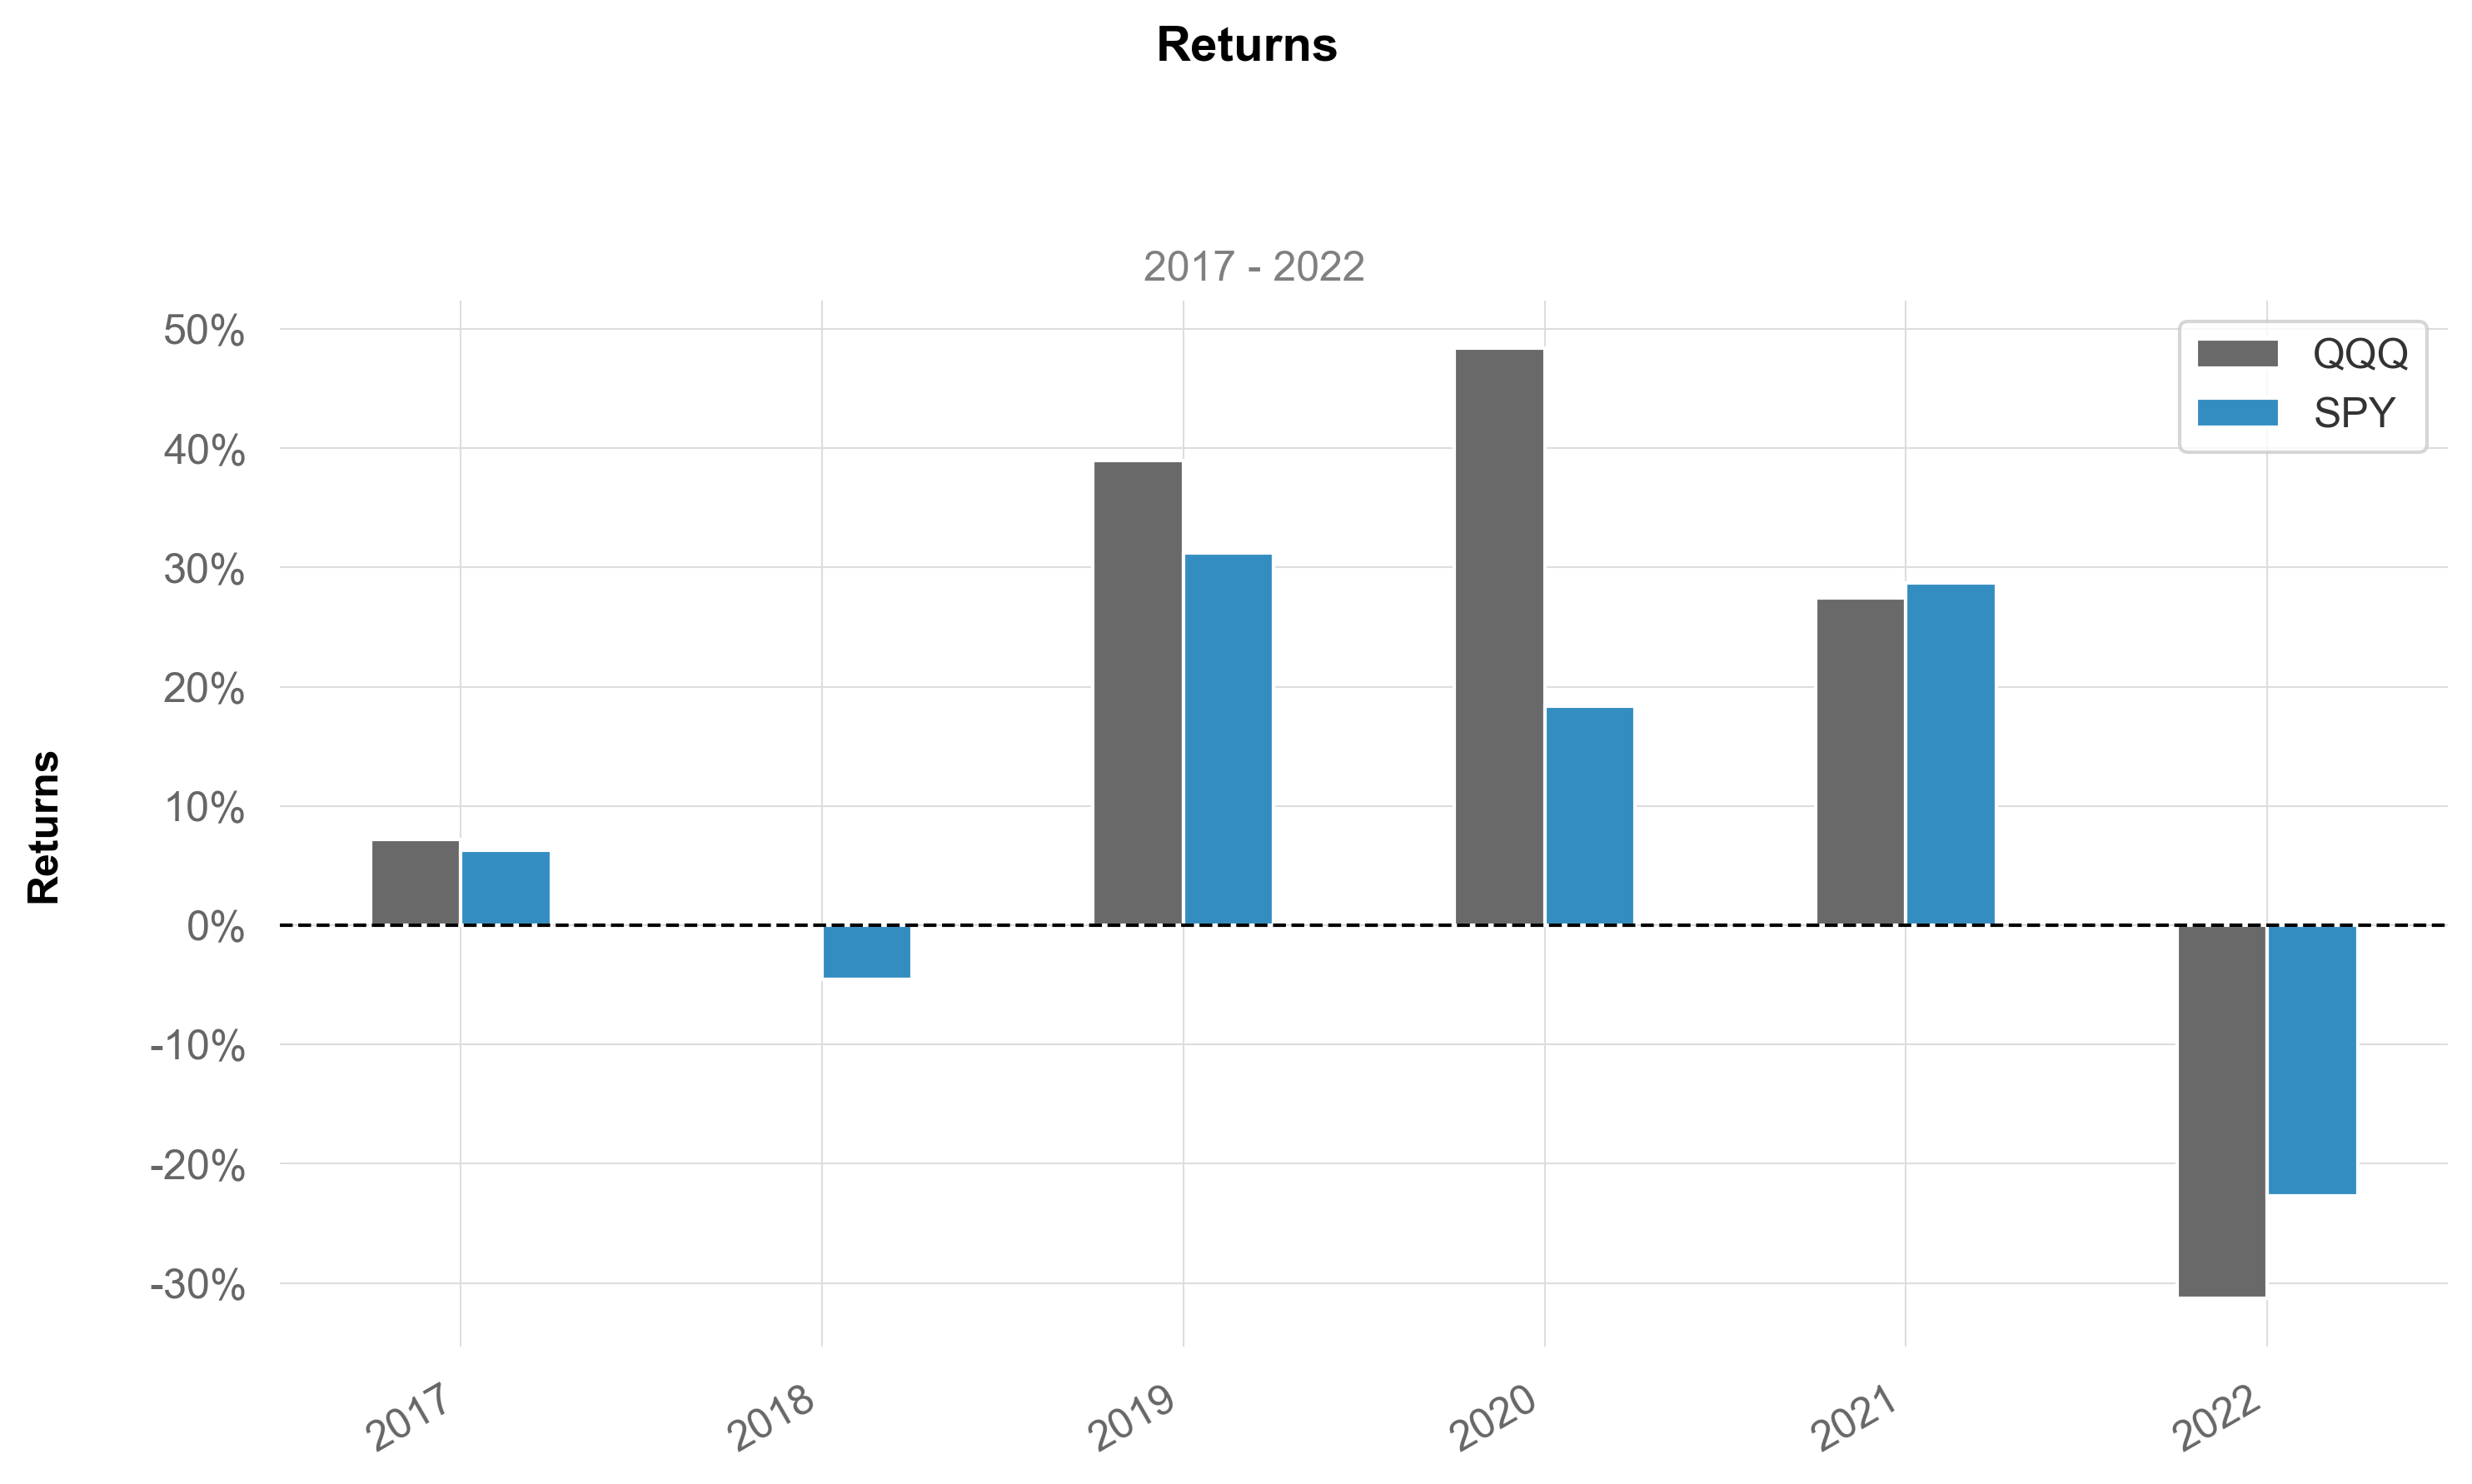

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
benchmark = utils.download_returns('QQQ', '5y')
plot_returns_bars(returns, benchmark, returns_label="SPY", benchmark_label="QQQ")

In [ ]:
#| export
def plot_timeseries(returns, benchmark=None,
                    title="Returns", compound=False, cumulative=True,
                    fill=False, returns_label="Strategy", benchmark_label="Benchmark",
                    hline=None, hlw=None, hlcolor="red", hllabel="",
                    percent=True, match_volatility=False, log_scale=False,
                    resample=None, lw=1.5, figsize=(10, 6), ylabel="",
                    grayscale=False, fontname="Arial",
                    subtitle=True, savefig=None, show=True):

    colors, ls, alpha = _get_colors(grayscale)

    returns.fillna(0, inplace=True)
    if isinstance(benchmark, pd.Series):
        benchmark.fillna(0, inplace=True)

    if match_volatility and benchmark is None:
        raise ValueError('match_volatility requires passing of '
                         'benchmark.')
    if match_volatility and benchmark is not None:
        bmark_vol = benchmark.std()
        returns = (returns / returns.std()) * bmark_vol

    # ---------------
    if compound is True:
        if cumulative:
            returns = stats.compsum(returns)
            if isinstance(benchmark, pd.Series):
                benchmark = stats.compsum(benchmark)
        else:
            returns = returns.cumsum()
            if isinstance(benchmark, pd.Series):
                benchmark = benchmark.cumsum()

    if resample:
        returns = returns.resample(resample)
        returns = returns.last() if compound is True else returns.sum()
        if isinstance(benchmark, pd.Series):
            benchmark = benchmark.resample(resample)
            benchmark = benchmark.last(
            ) if compound is True else benchmark.sum()
    # ---------------

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                  " % (
            returns.index.date[:1][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y')
        ), fontsize=12, color='gray')

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    if isinstance(benchmark, pd.Series):
        ax.plot(benchmark, lw=lw, ls=ls, label=benchmark_label, color=colors[0])

    alpha = .25 if grayscale else 1
    ax.plot(returns, lw=lw, label=returns_label, color=colors[1], alpha=alpha)

    if fill:
        ax.fill_between(returns.index, 0, returns, color=colors[1], alpha=.25)

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # use a more precise date string for the x axis locations in the toolbar
    # ax.fmt_xdata = _mdates.DateFormatter('%Y-%m-%d')

    if hline:
        if grayscale:
            hlcolor = 'black'
        ax.axhline(hline, ls="--", lw=hlw, color=hlcolor,
                   label=hllabel, zorder=2)

    ax.axhline(0, ls="-", lw=1,
               color='gray', zorder=1)
    ax.axhline(0, ls="--", lw=1,
               color='white' if grayscale else 'black', zorder=2)

    if isinstance(benchmark, pd.Series) or hline:
        ax.legend(fontsize=12)

    plt.yscale("symlog" if log_scale else "linear")

    if percent:
        ax.yaxis.set_major_formatter(FuncFormatter(format_pct_axis))
        # ax.yaxis.set_major_formatter(_plt.FuncFormatter(
        #     lambda x, loc: "{:,}%".format(int(x*100))))

    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel(ylabel, fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
    ax.yaxis.set_label_coords(-.1, .5)

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

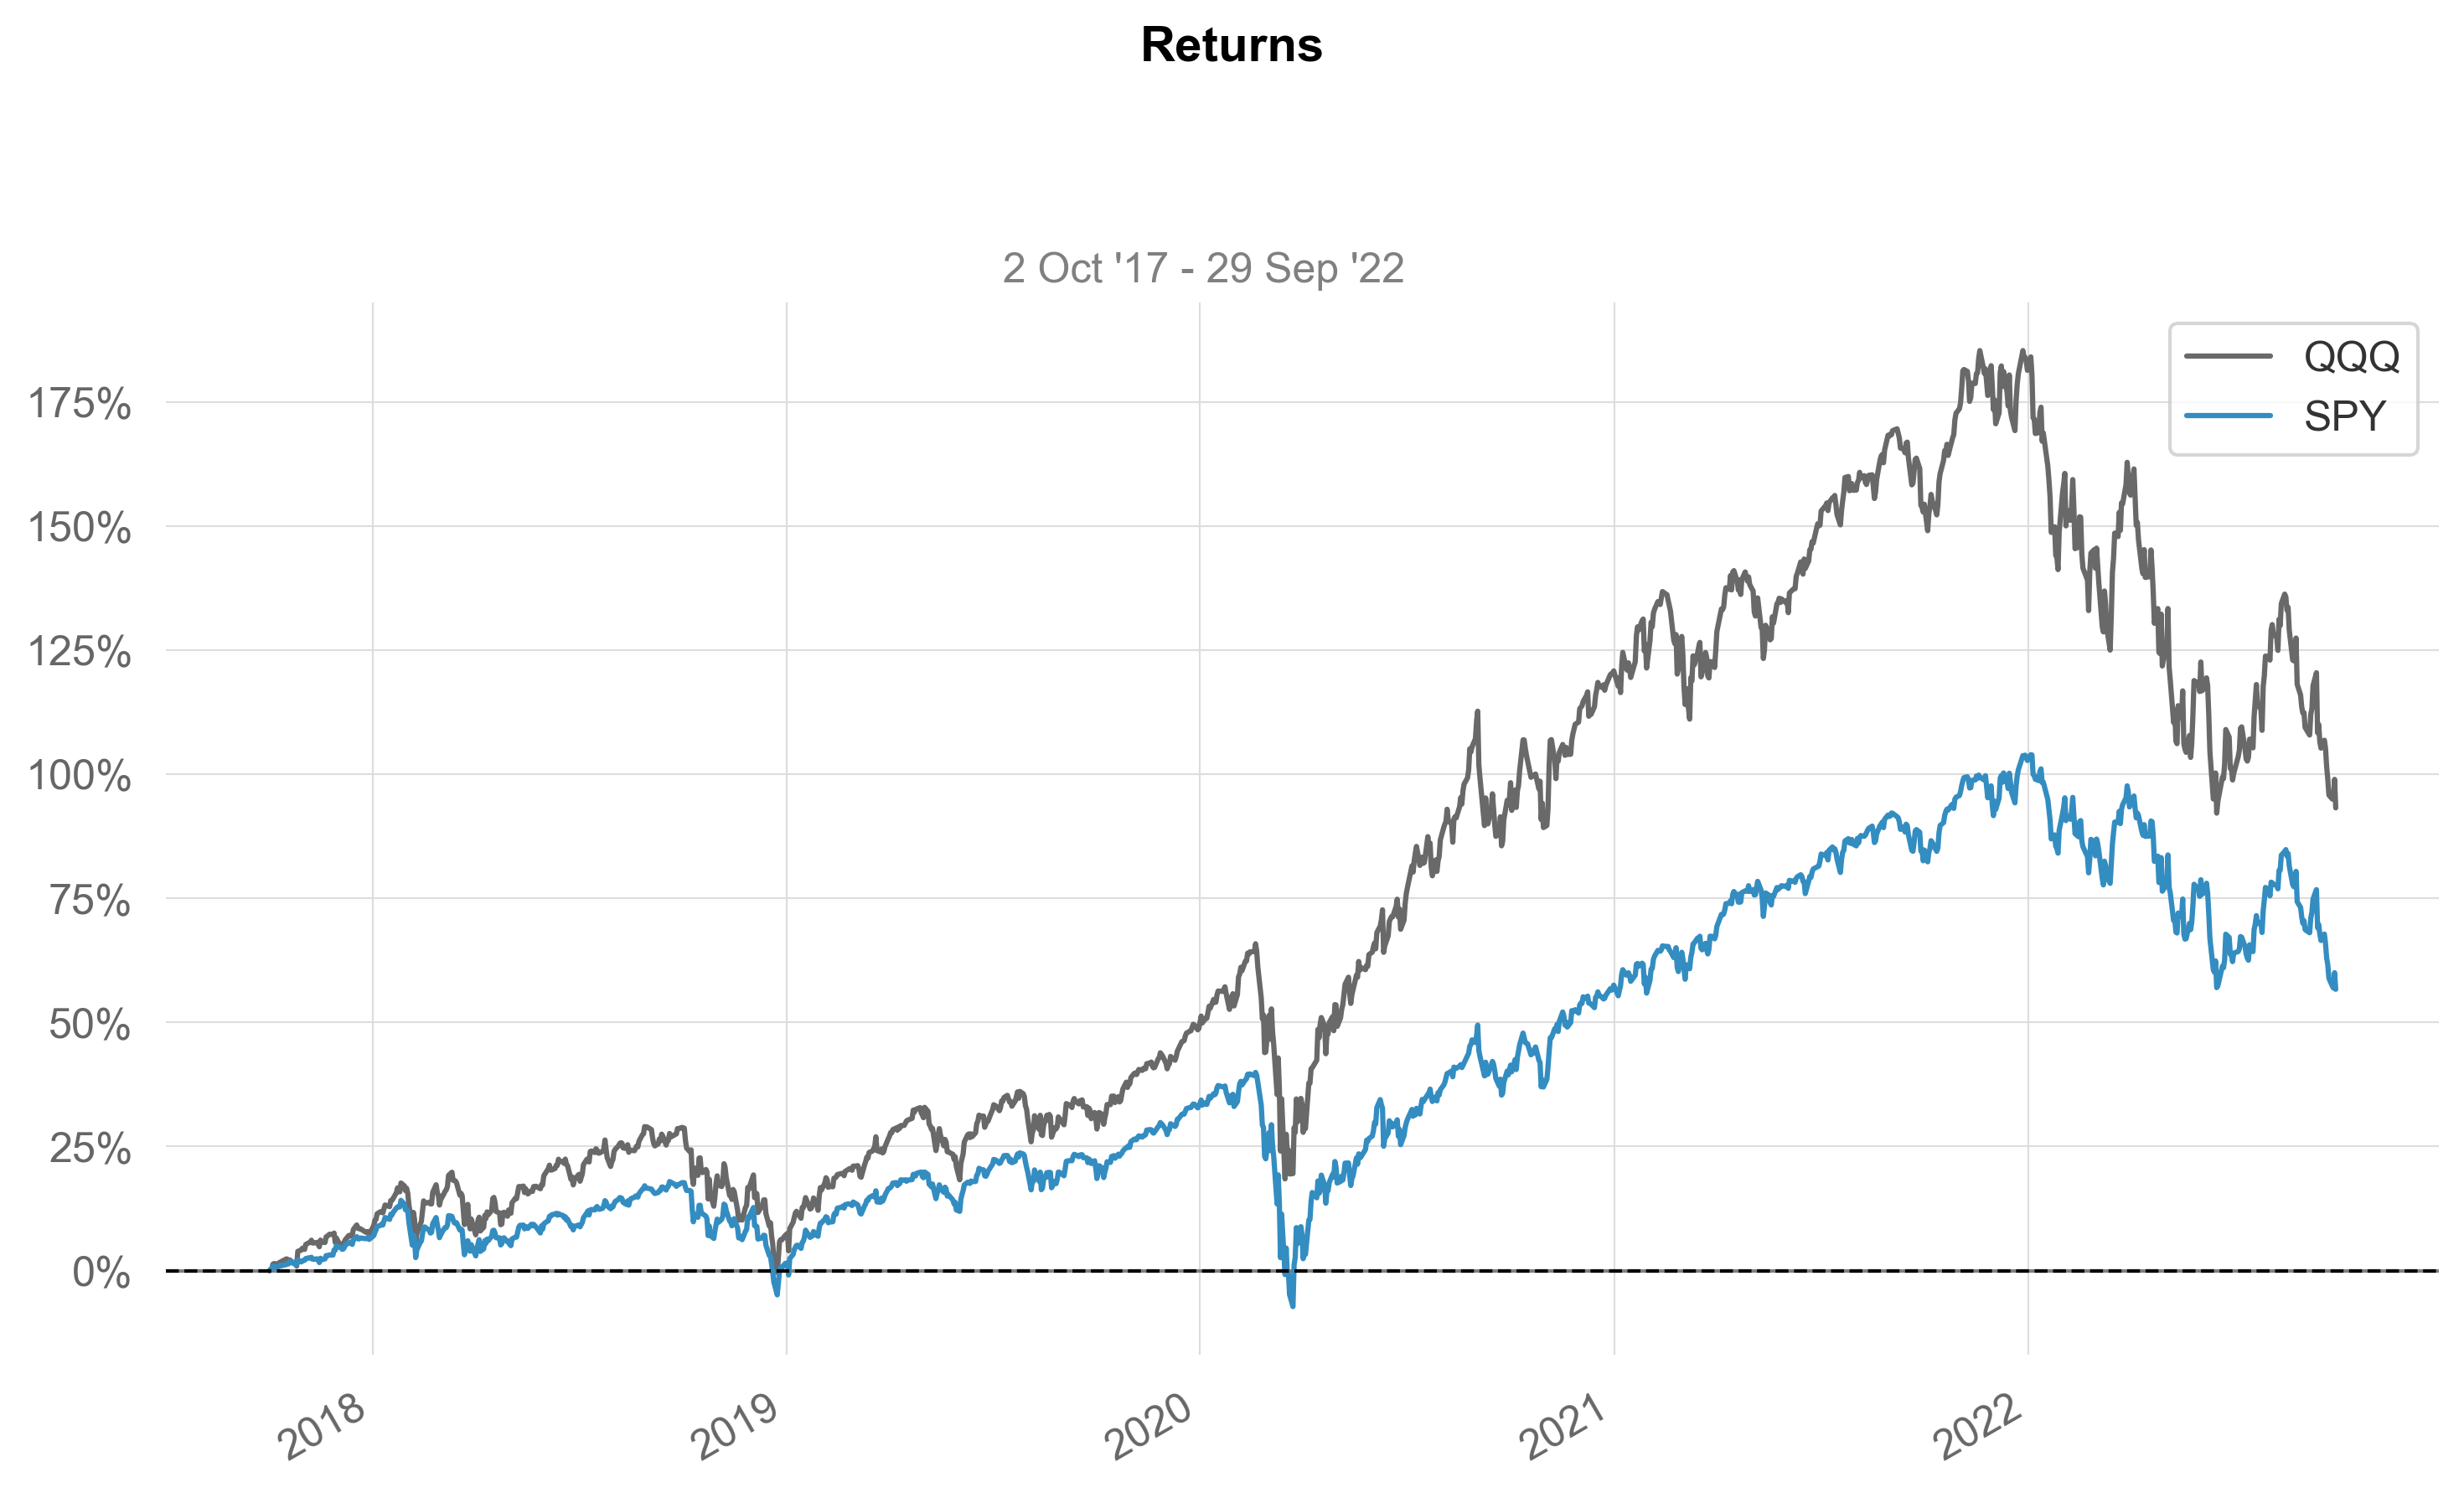

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
benchmark = utils.download_returns('QQQ', '5y')
plot_timeseries(returns, benchmark, compound = True, returns_label="SPY", benchmark_label="QQQ")

In [ ]:
#| export
def plot_histogram(returns, resample="M", bins=20,
                   fontname='Arial', grayscale=False,
                   title="Returns", kde=True, figsize=(10, 6),
                   ylabel=True, subtitle=True, compounded=True,
                   savefig=None, show=True):

    colors = ['#348dc1', '#003366', 'red']
    if grayscale:
        colors = ['silver', 'gray', 'black']

    apply_fnc = stats.comp if compounded else np.sum
    returns = returns.fillna(0).resample(resample).apply(
        apply_fnc).resample(resample).last()

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            returns.index.date[:1][0].strftime('%Y'),
            returns.index.date[-1:][0].strftime('%Y')
        ), fontsize=12, color='gray')

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    ax.axvline(returns.mean(), ls="--", lw=1.5,
               color=colors[2], zorder=2, label="Average")

    sns.histplot(returns, bins=bins,
                  color=colors[0],
                  alpha=1,
                  kde=kde,
                  stat="density",
                  ax=ax)
    sns.kdeplot(returns, color='black', linewidth=1.5)

    ax.xaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, loc: "{:,}%".format(int(x*100))))

    ax.axhline(0.01, lw=1, color="#000000", zorder=2)
    ax.axvline(0, lw=1, color="#000000", zorder=2)

    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel("Occurrences", fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.legend(fontsize=12)

    # fig.autofmt_xdate()

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

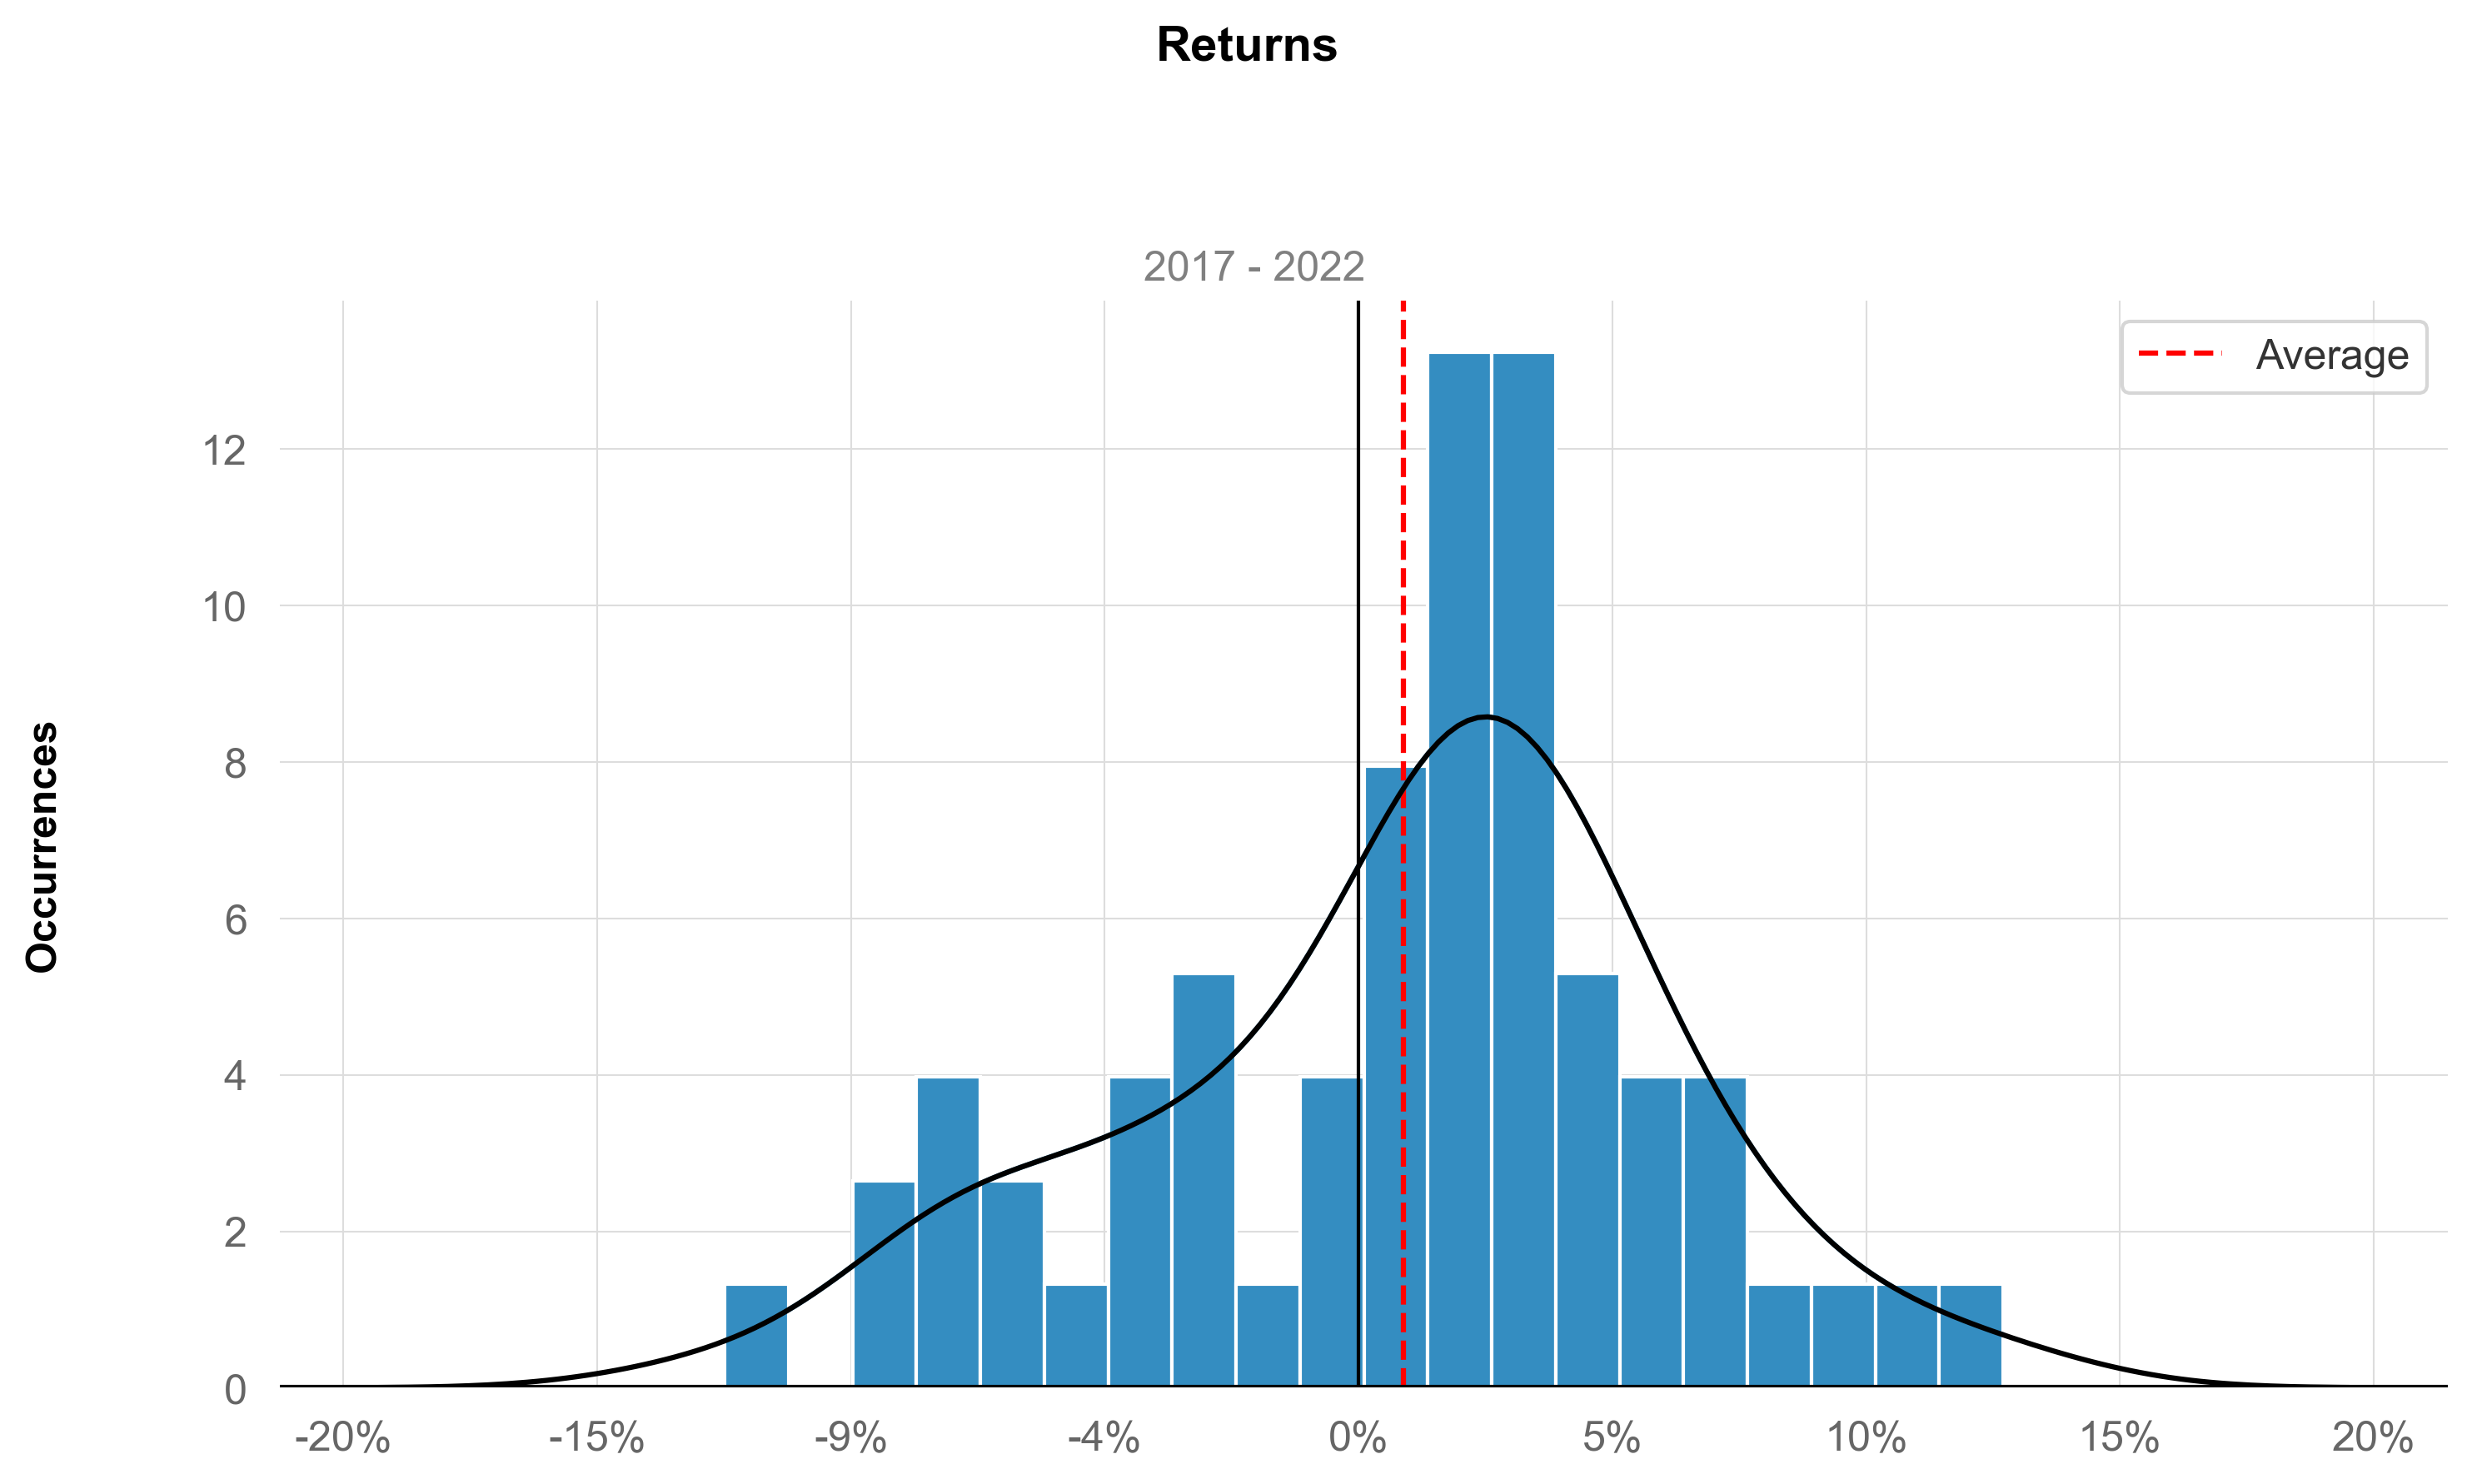

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
plot_histogram(returns)

In [ ]:
#| export
def plot_rolling_stats(returns, benchmark=None, title="",
                       returns_label="Strategy", benchmark_label="Benchmark",
                       hline=None, hlw=None, hlcolor="red", hllabel="",
                       lw=1.5, figsize=(10, 6), ylabel="",
                       grayscale=False, fontname="Arial", subtitle=True,
                       savefig=None, show=True):

    colors, _, _ = _get_colors(grayscale)

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    df = pd.DataFrame(index=returns.index, data={returns_label: returns})
    if isinstance(benchmark, pd.Series):
        df['Benchmark'] = benchmark[benchmark.index.isin(returns.index)]
        df = df[['Benchmark', returns_label]].dropna()
        ax.plot(df['Benchmark'], lw=lw, label=benchmark_label,
                color=colors[0], alpha=.8)

    ax.plot(df[returns_label].dropna(), lw=lw,
            label=returns_label, color=colors[1])

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # use a more precise date string for the x axis locations in the toolbar
    # ax.fmt_xdata = _mdates.DateFormatter('%Y-%m-%d')\
    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            df.index.date[:1][0].strftime('%e %b \'%y'),
            df.index.date[-1:][0].strftime('%e %b \'%y')
        ), fontsize=12, color='gray')

    if hline:
        if grayscale:
            hlcolor = 'black'
        ax.axhline(hline, ls="--", lw=hlw, color=hlcolor,
                   label=hllabel, zorder=2)

    ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)

    if ylabel:
        ax.set_ylabel(ylabel, fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax.legend(fontsize=12)

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)
    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

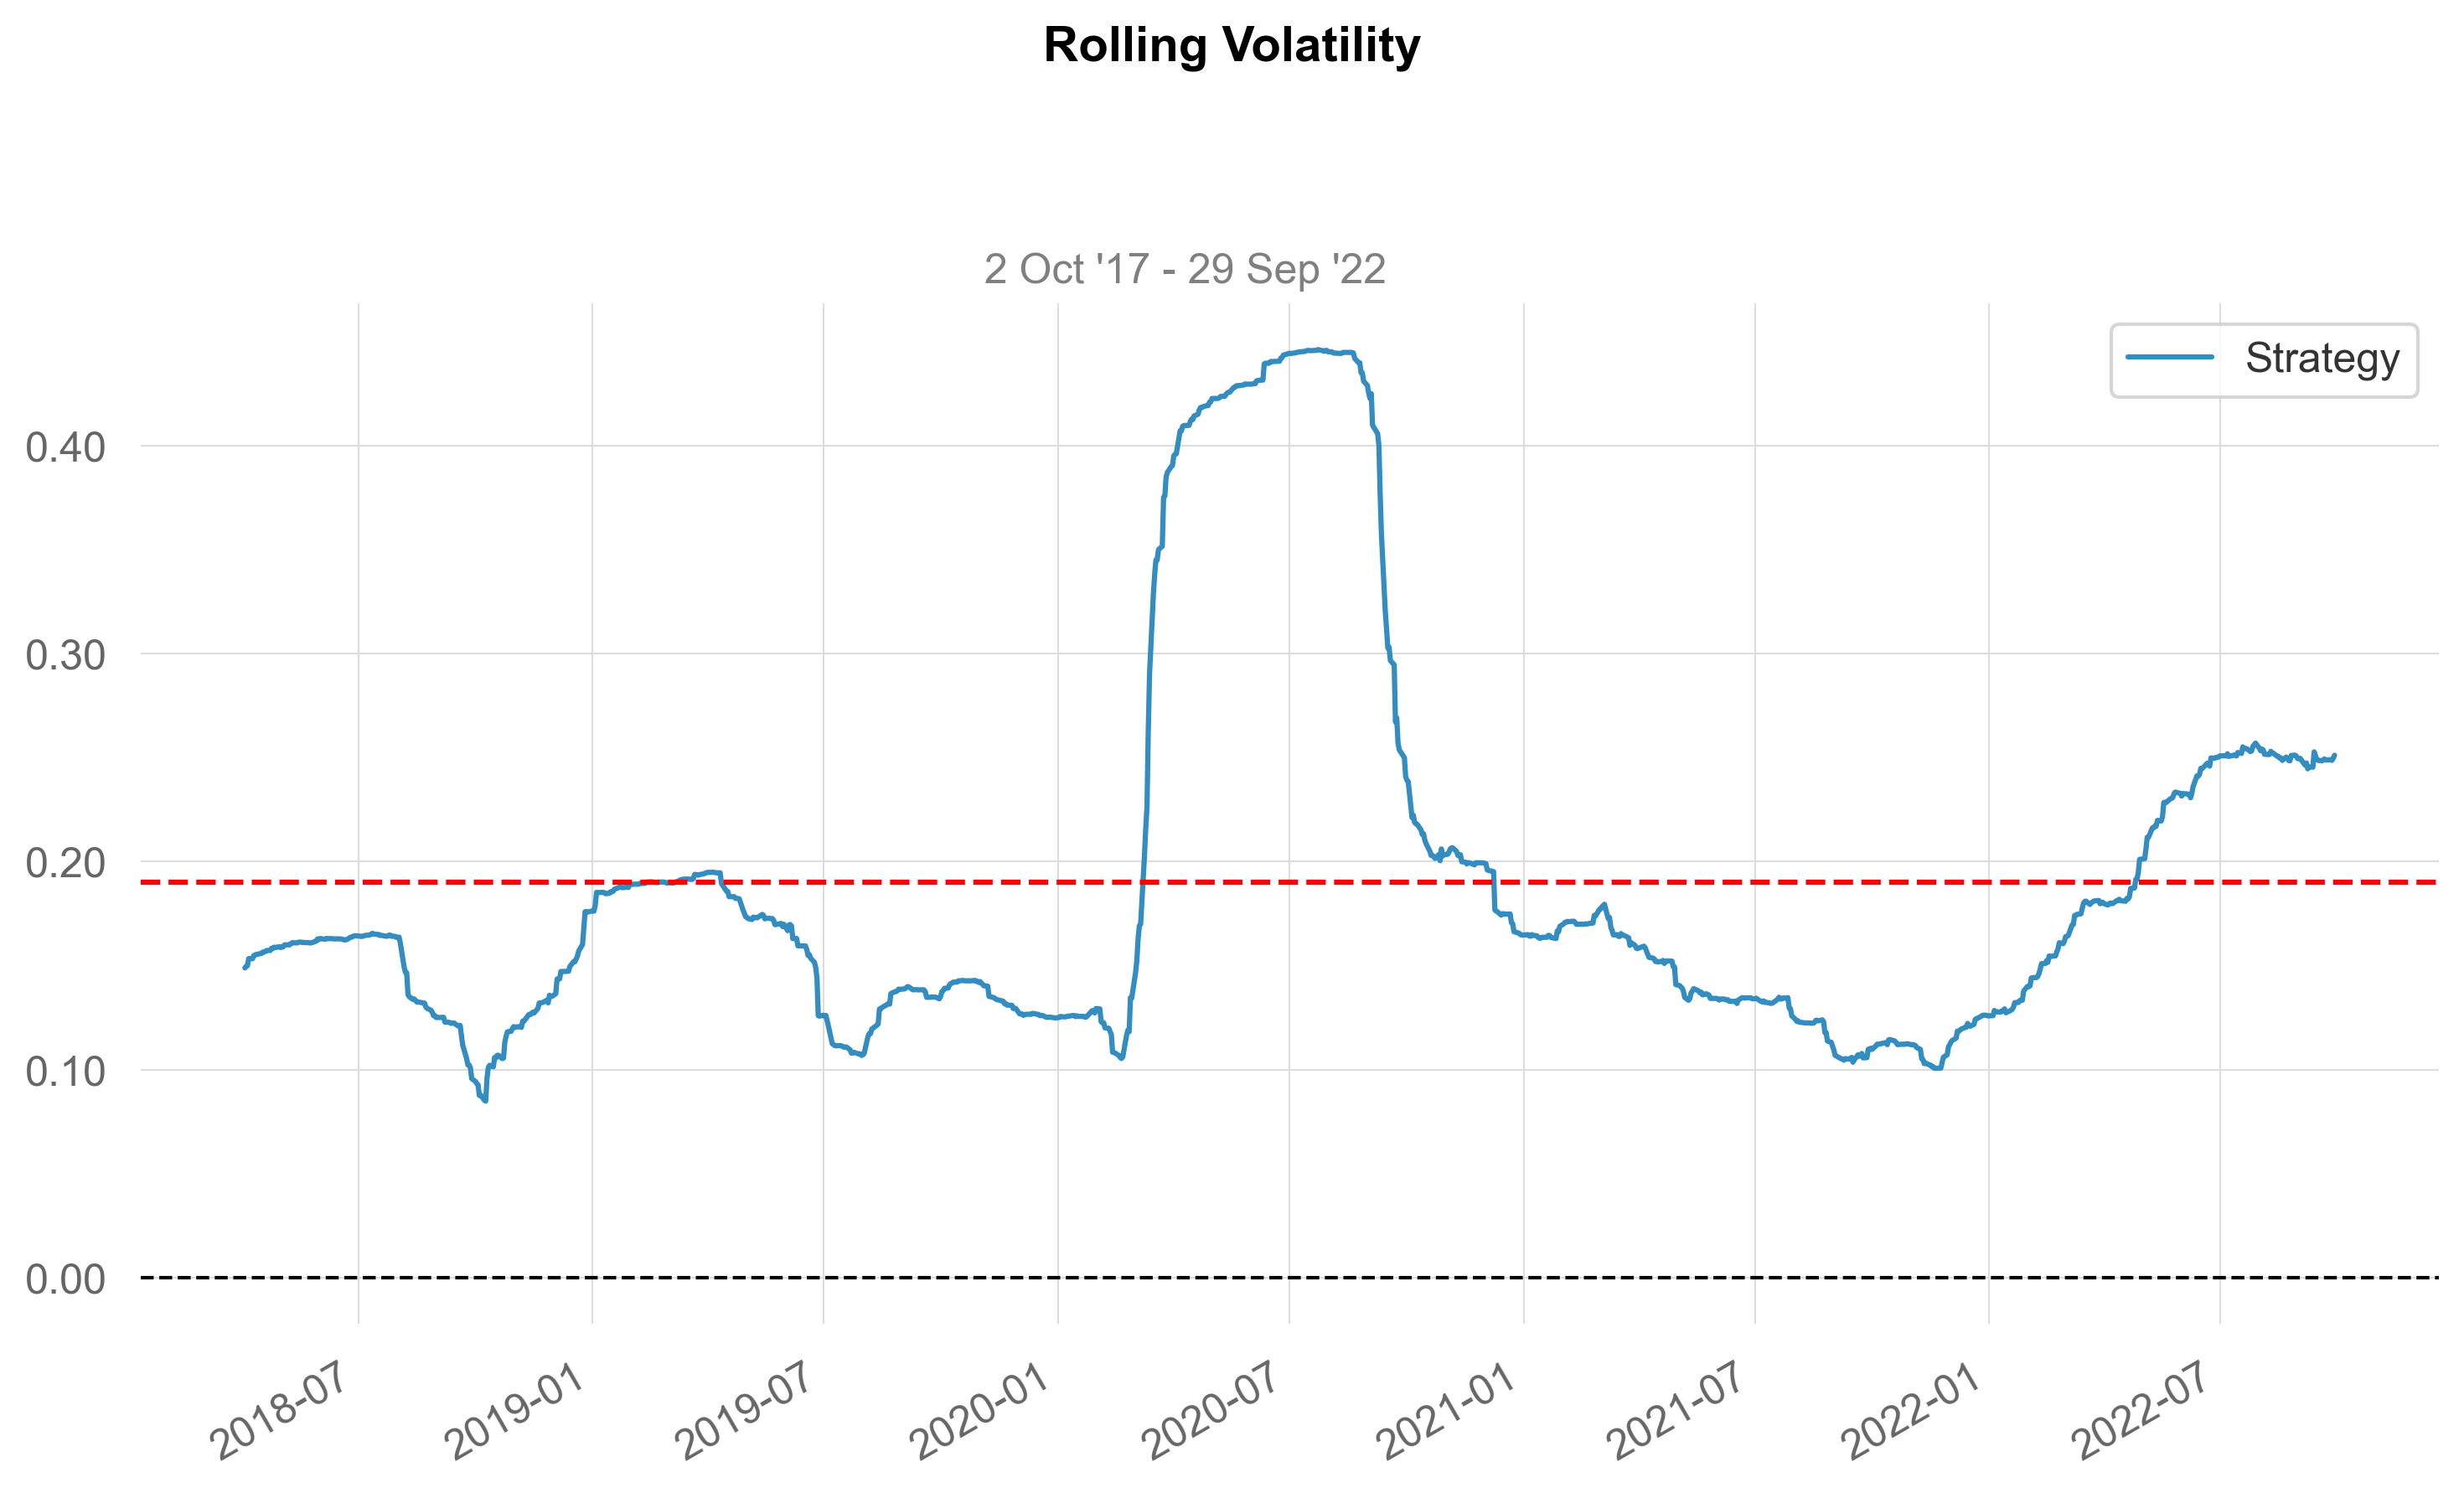

In [ ]:
#| eval: false
returns = stats.rolling_volatility(utils.download_returns('SPY', '5y'))
plot_rolling_stats(returns, title = 'Rolling Volatility', hline=returns.mean(), hlw=1.5)

In [ ]:
#| export
def plot_rolling_beta(returns, benchmark,
                      window1=126, window1_label="",
                      window2=None, window2_label="",
                      title="", hlcolor="red", figsize=(10, 6),
                      grayscale=False, fontname="Arial", lw=1.5,
                      ylabel=True, subtitle=True, savefig=None, show=True):

    colors, _, _ = _get_colors(grayscale)

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            returns.index.date[:1][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y')
        ), fontsize=12, color='gray')

    beta = stats.rolling_greeks(returns, benchmark, window1)['beta'].fillna(0)
    ax.plot(beta, lw=lw, label=window1_label, color=colors[1])

    if window2:
        ax.plot(stats.rolling_greeks(returns, benchmark, window2)['beta'],
                lw=lw, label=window2_label, color="gray", alpha=0.8)
    mmin = min([-100, int(beta.min()*100)])
    mmax = max([100, int(beta.max()*100)])
    step = 50 if (mmax-mmin) >= 200 else 100
    ax.set_yticks([x / 100 for x in list(range(mmin, mmax, step))])

    hlcolor = 'black' if grayscale else hlcolor
    ax.axhline(beta.mean(), ls="--", lw=1.5,
               color=hlcolor, zorder=2)

    ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)

    fig.autofmt_xdate()

    # use a more precise date string for the x axis locations in the toolbar
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    if ylabel:
        ax.set_ylabel("Beta", fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.legend(fontsize=12)
    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

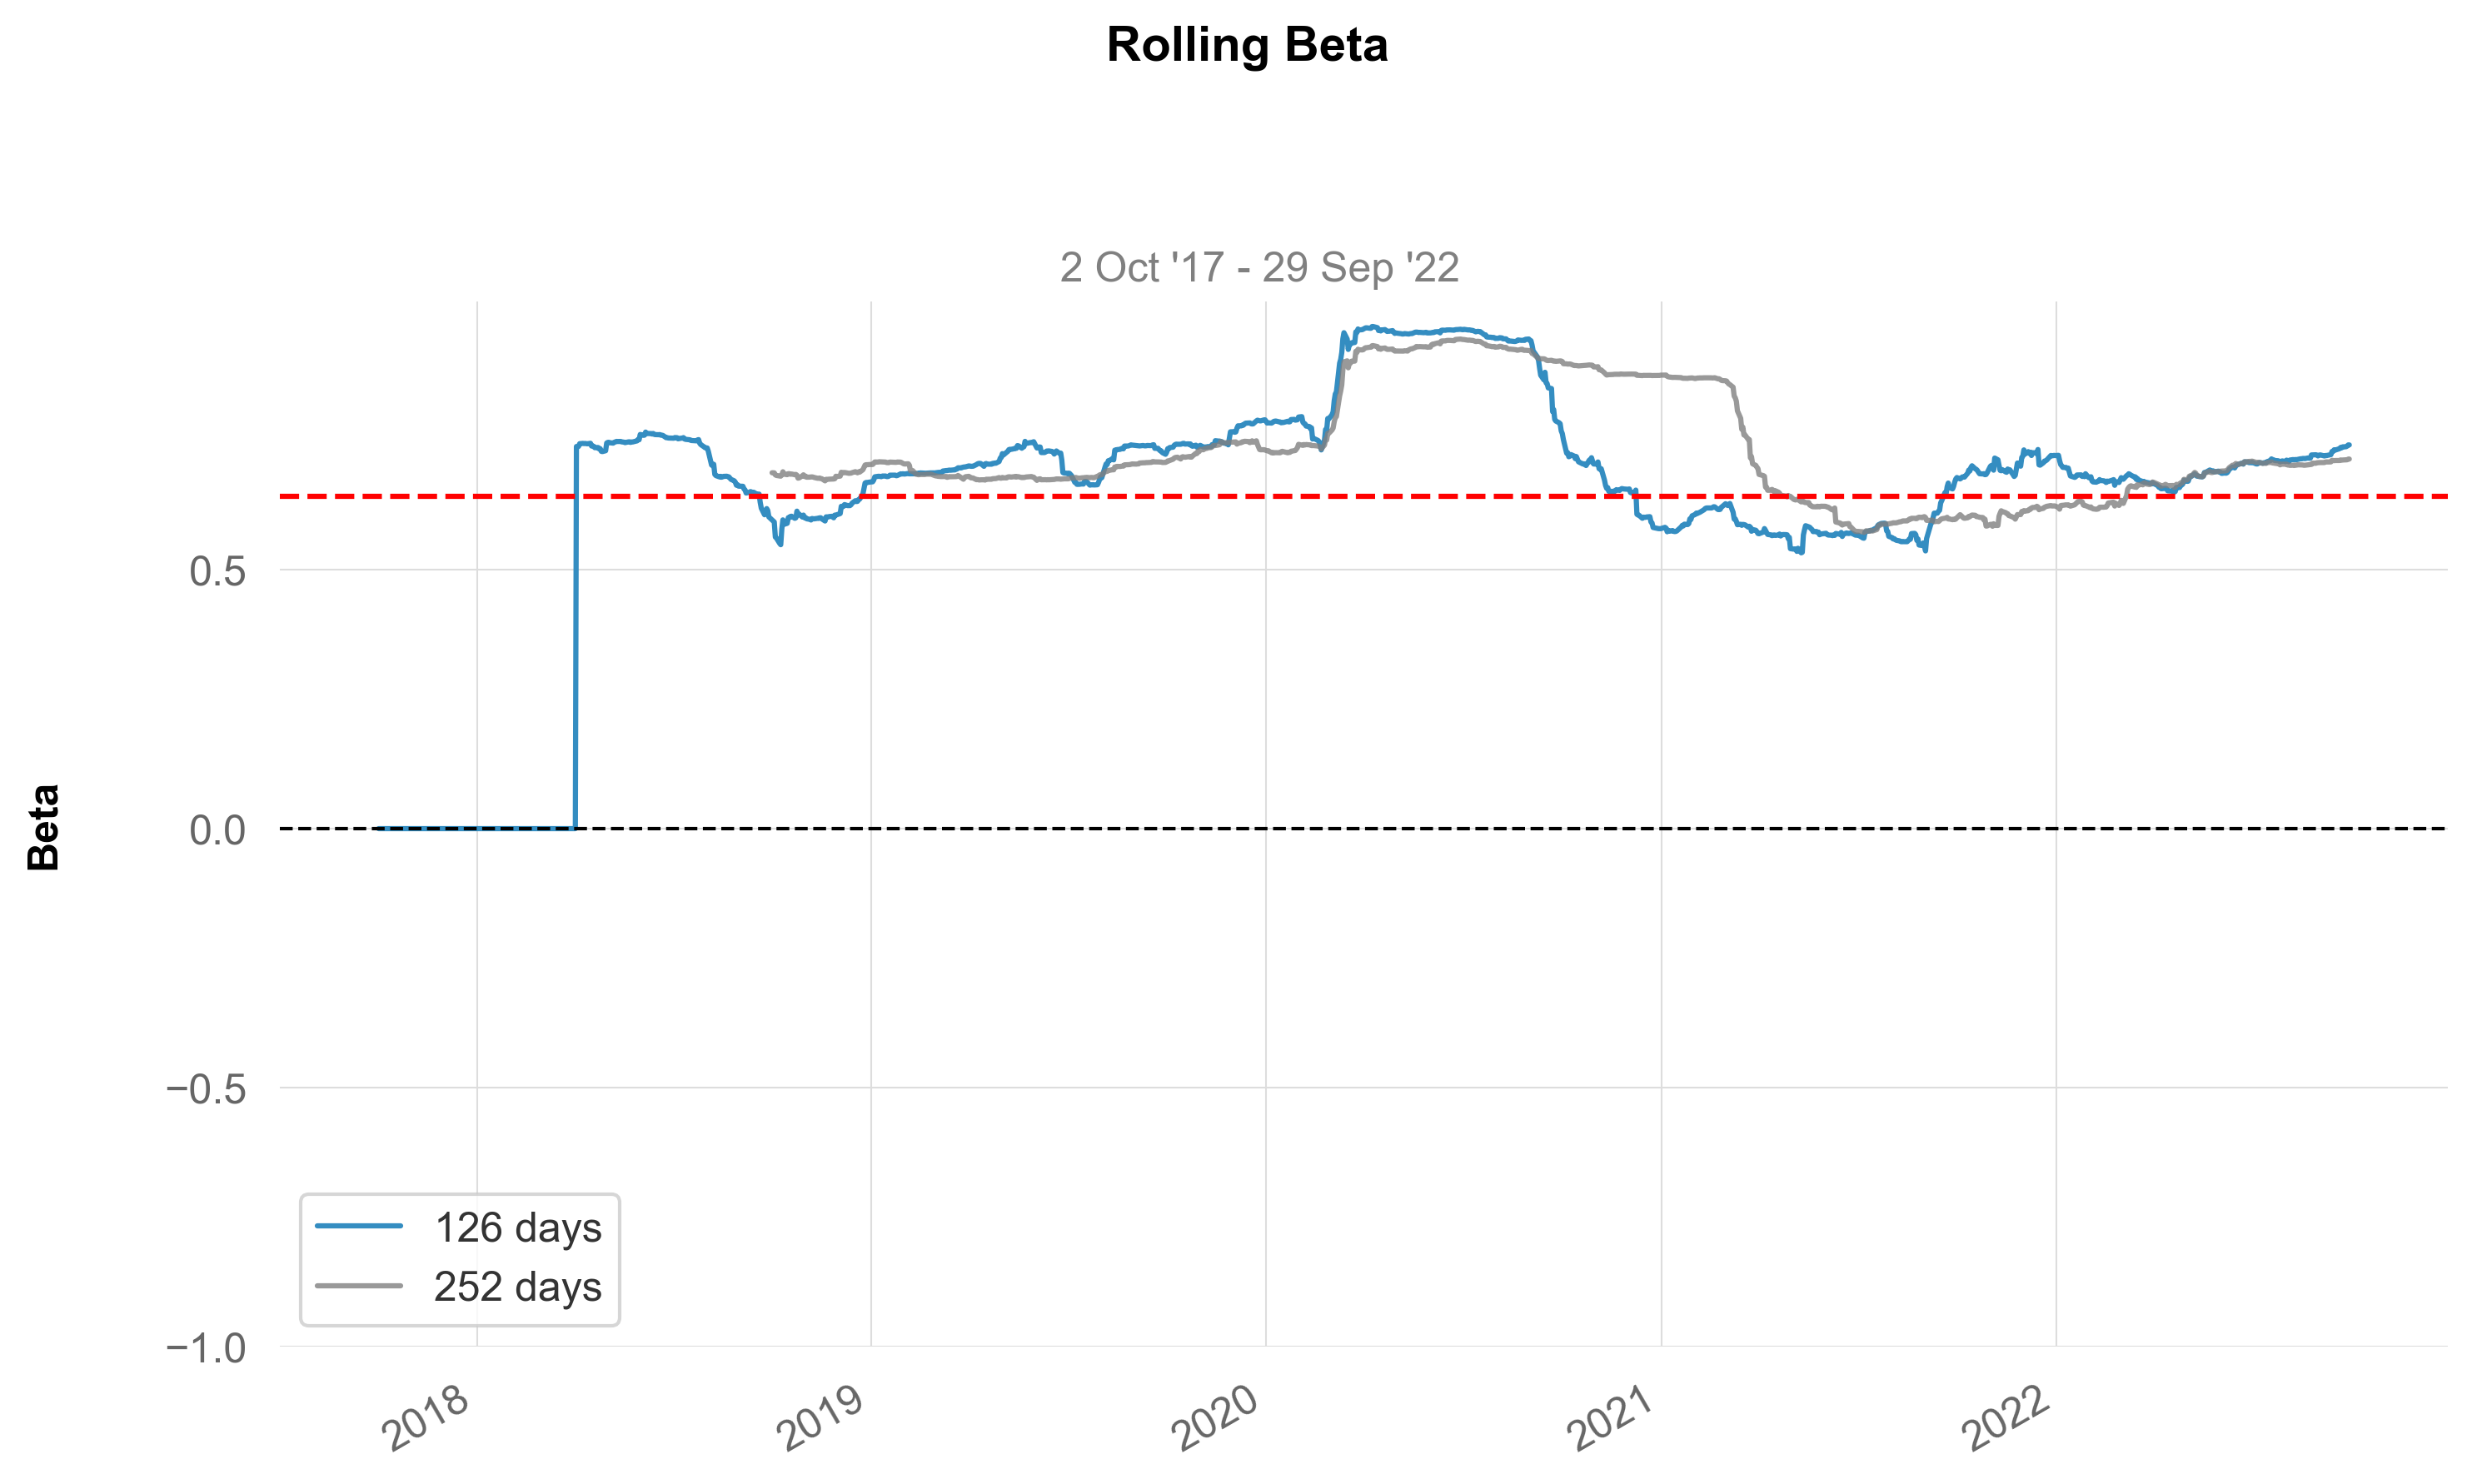

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
benchmark = utils.download_returns('QQQ', '5y')
plot_rolling_beta(returns, benchmark, title="Rolling Beta", window1_label='126 days', window2=252, window2_label='252 days')

In [ ]:
#| export
def plot_longest_drawdowns(returns, periods=5, lw=1.5,
                           fontname='Arial', grayscale=False,
                           log_scale=False, figsize=(10, 6), ylabel=True,
                           subtitle=True, compounded=True,
                           savefig=None, show=True):

    colors = ['#348dc1', '#003366', 'red']
    if grayscale:
        colors = ['#000000'] * 3

    dd = stats.to_drawdown_series(returns.fillna(0))
    dddf = stats.drawdown_details(dd)
    longest_dd = dddf.sort_values(
        by='days', ascending=False, kind='mergesort')[:periods]

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle("Worst %.0f Drawdown Periods\n" %
                 periods, y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")
    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            returns.index.date[:1][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y')
        ), fontsize=12, color='gray')

    fig.set_facecolor('white')
    ax.set_facecolor('white')
    series = stats.compsum(returns) if compounded else returns.cumsum()
    ax.plot(series, lw=lw, label="Backtest", color=colors[0])

    highlight = 'black' if grayscale else 'red'
    for _, row in longest_dd.iterrows():
        ax.axvspan(*mdates.datestr2num([str(row['start']), str(row['end'])]),
                   color=highlight, alpha=.1)

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # use a more precise date string for the x axis locations in the toolbar
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
    plt.yscale("symlog" if log_scale else "linear")
    if ylabel:
        ax.set_ylabel("Cumulative Returns", fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.yaxis.set_major_formatter(FuncFormatter(format_pct_axis))
    # ax.yaxis.set_major_formatter(_plt.FuncFormatter(
    #     lambda x, loc: "{:,}%".format(int(x*100))))

    fig.autofmt_xdate()

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

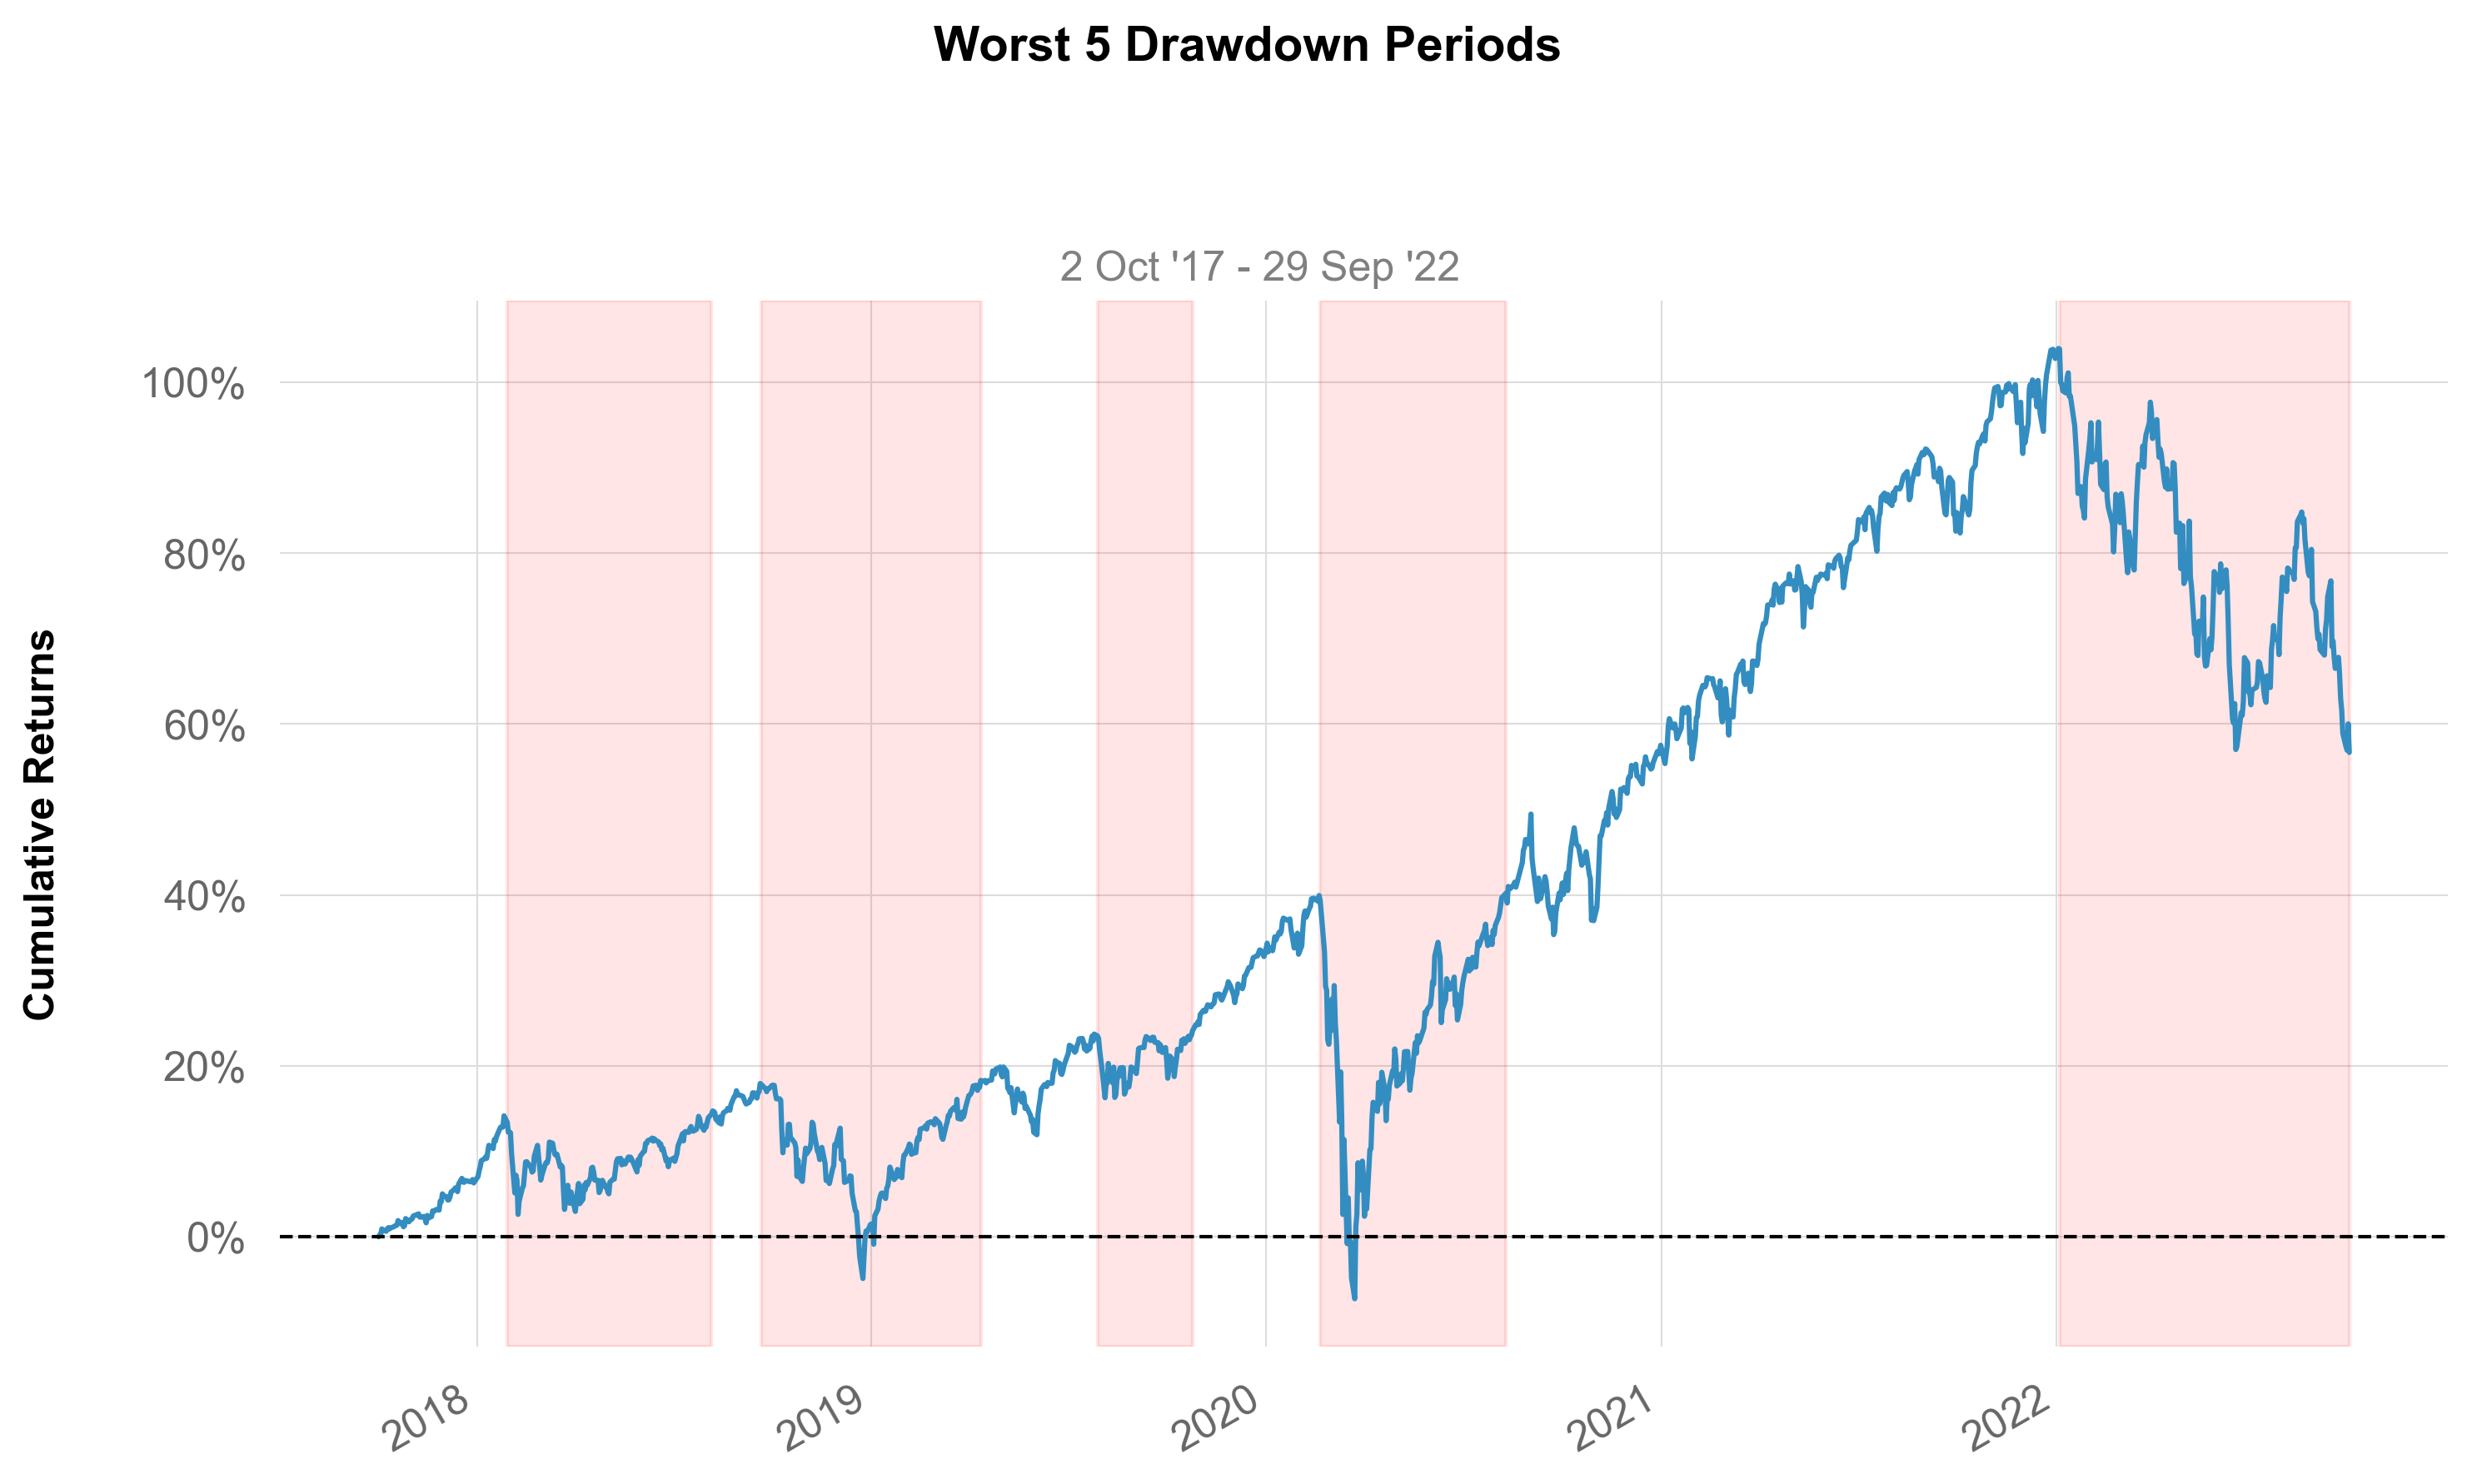

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
plot_longest_drawdowns(returns)

In [ ]:
#| export
def plot_distribution(returns, figsize=(10, 6),
                      fontname='Arial', grayscale=False, ylabel=True,
                      subtitle=True, compounded=True,
                      savefig=None, show=True):

    colors = FLATUI_COLORS
    if grayscale:
        colors = ['#f9f9f9', '#dddddd', '#bbbbbb', '#999999', '#808080']
    # colors, ls, alpha = _get_colors(grayscale)

    port = pd.DataFrame(returns.fillna(0))
    port.columns = ['Daily']

    apply_fnc = stats.comp if compounded else np.sum

    port['Weekly'] = port['Daily'].resample(
        'W-MON').apply(apply_fnc)
    port['Weekly'].ffill(inplace=True)

    port['Monthly'] = port['Daily'].resample(
        'M').apply(apply_fnc)
    port['Monthly'].ffill(inplace=True)

    port['Quarterly'] = port['Daily'].resample(
        'Q').apply(apply_fnc)
    port['Quarterly'].ffill(inplace=True)

    port['Yearly'] = port['Daily'].resample(
        'A').apply(apply_fnc)
    port['Yearly'].ffill(inplace=True)

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.suptitle("Return Quantiles\n", y=.99,
                 fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            returns.index.date[:1][0].strftime('%e %b \'%y'),
            returns.index.date[-1:][0].strftime('%e %b \'%y')
        ), fontsize=12, color='gray')

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    sns.boxplot(data=port, ax=ax, palette=tuple(colors[:5]))

    ax.yaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, loc: "{:,}%".format(int(x*100))))

    if ylabel:
        ax.set_ylabel('Returns', fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    fig.autofmt_xdate()

    try:
        plt.subplots_adjust(hspace=0)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

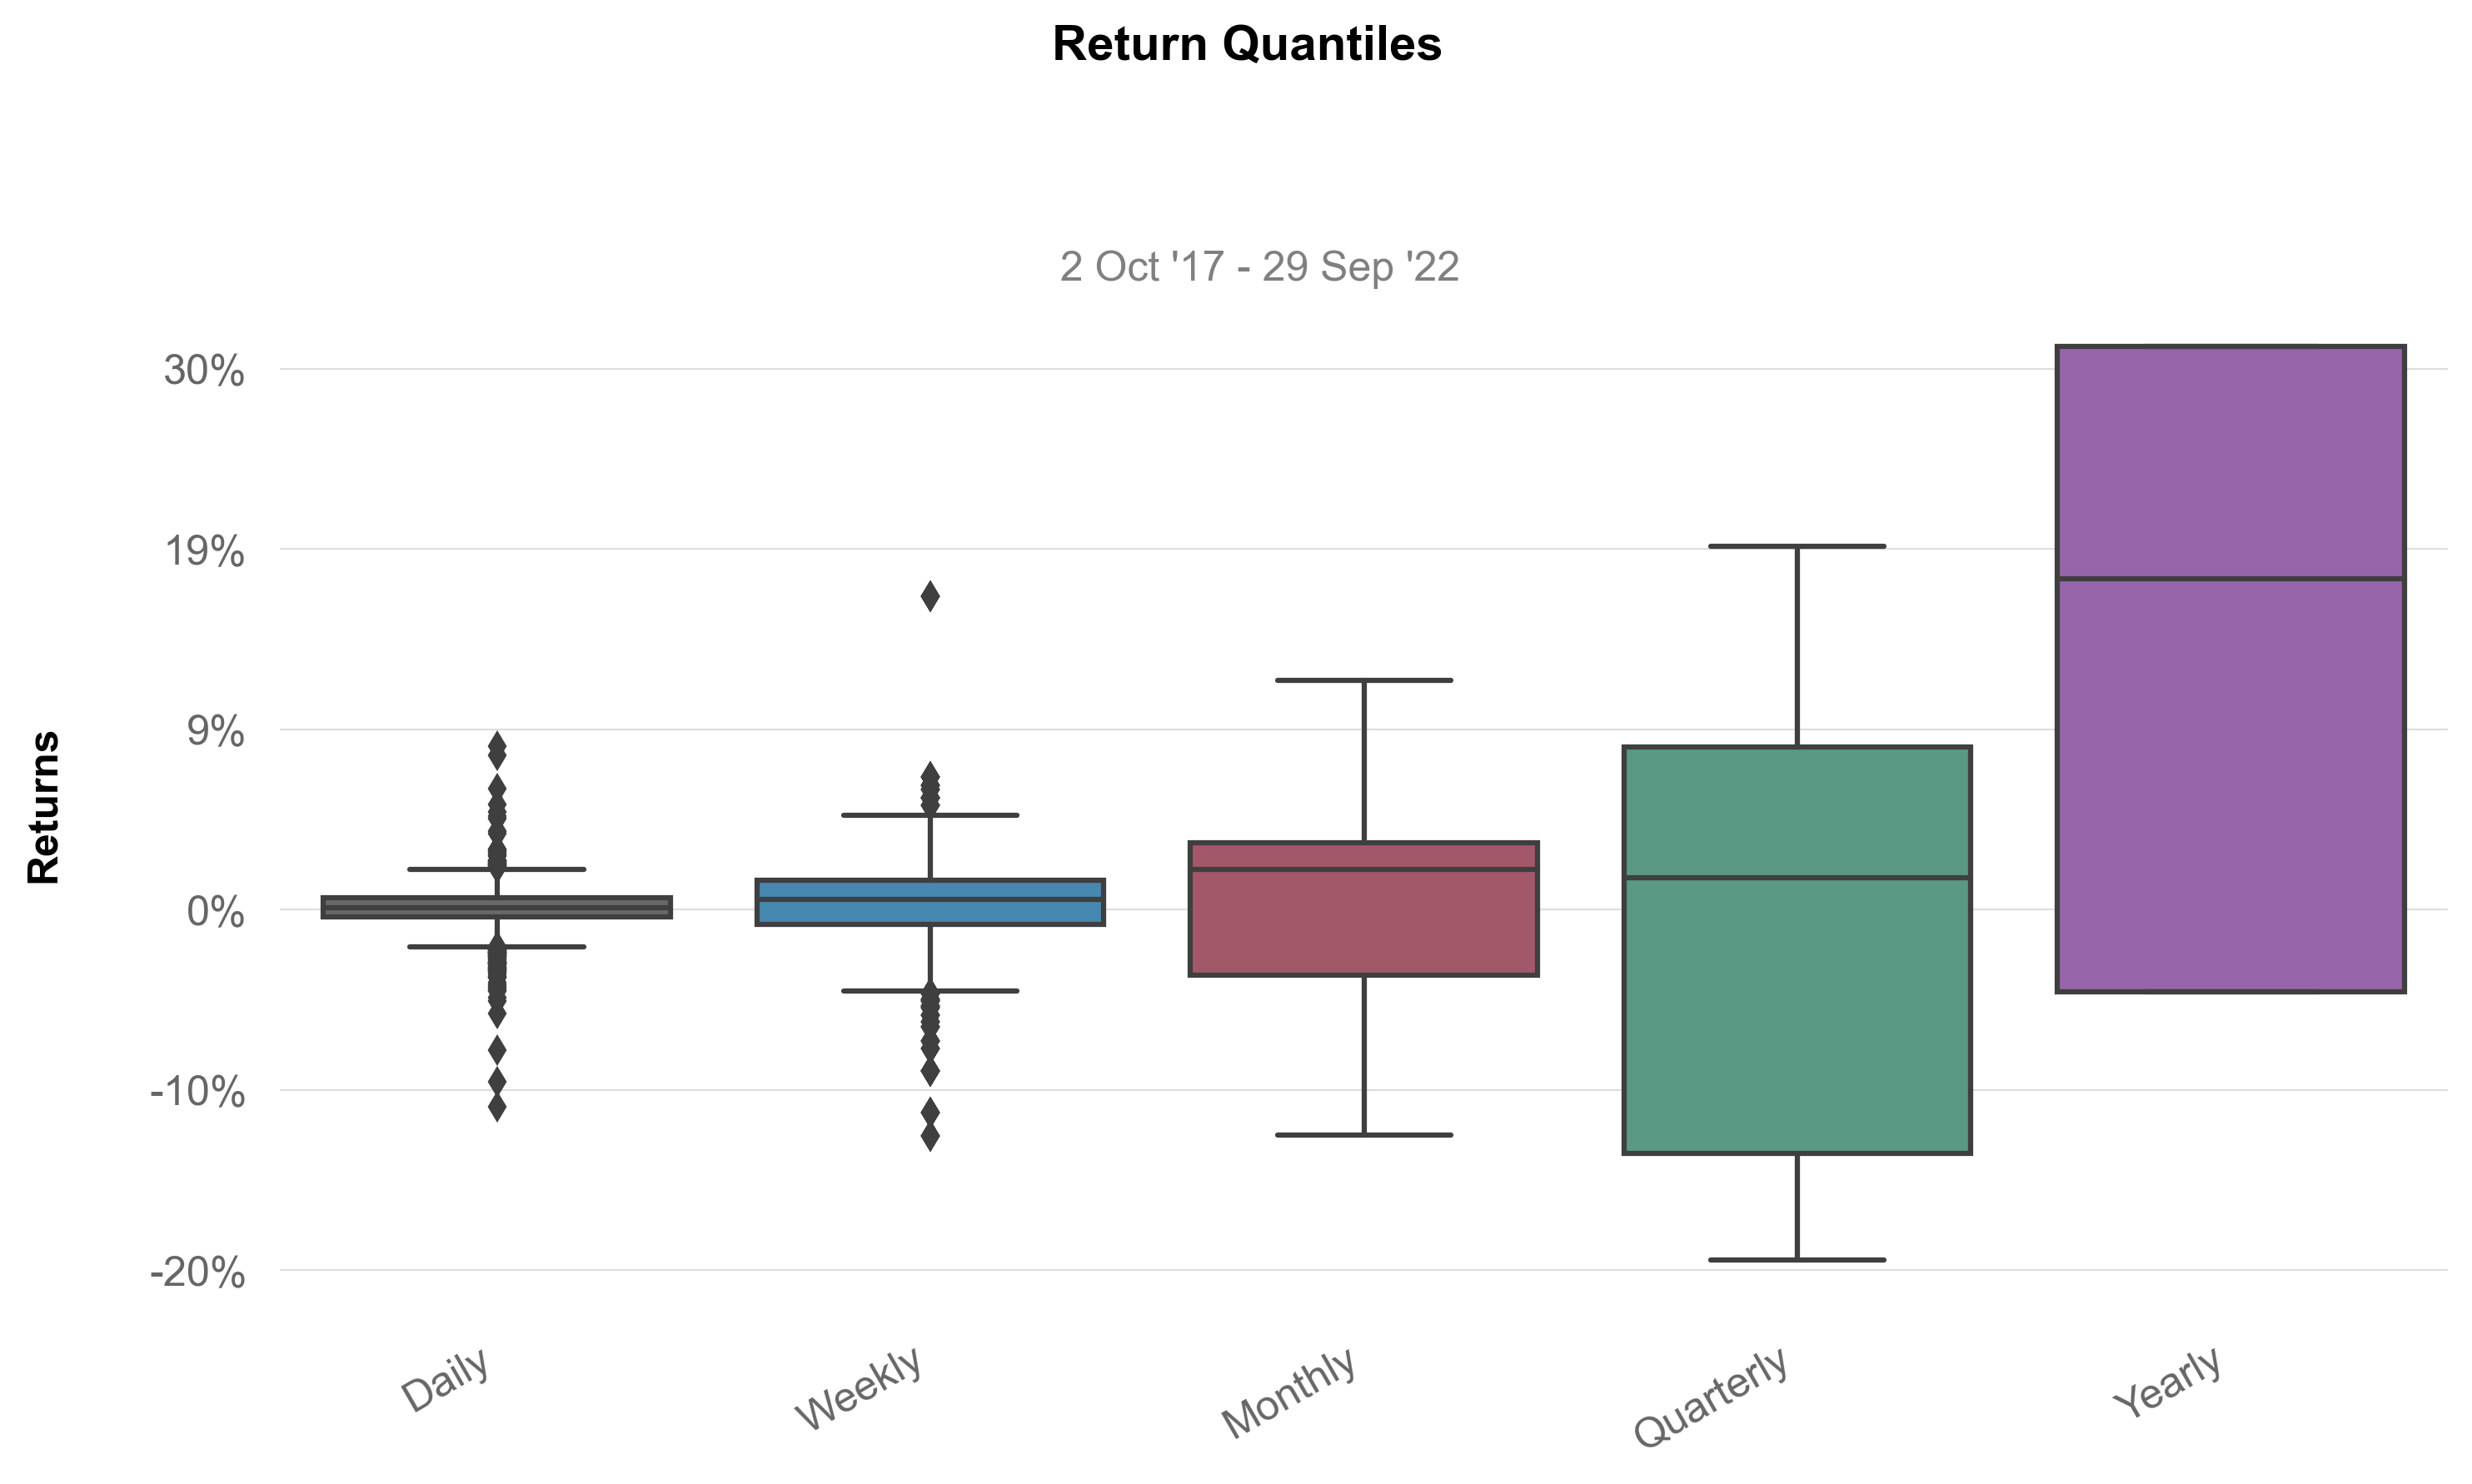

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
plot_distribution(returns)

In [ ]:
#| export
def plot_table(tbl, columns=None, title="", title_loc="left",
               header=True,
               colWidths=None,
               rowLoc='right',
               colLoc='right',
               colLabels=None,
               edges='horizontal',
               orient='horizontal',
               figsize=(5.5, 6),
               savefig=None,
               show=False):

    if columns is not None:
        try:
            tbl.columns = columns
        except Exception:
            pass

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111, frame_on=False)

    if title != "":
        ax.set_title(title, fontweight="bold",
                     fontsize=14, color="black", loc=title_loc)

    the_table = ax.table(cellText=tbl.values,
                         colWidths=colWidths,
                         rowLoc=rowLoc,
                         colLoc=colLoc,
                         edges=edges,
                         colLabels=(tbl.columns if header else colLabels),
                         loc='center',
                         zorder=2
                         )

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1, 1)

    for (row, col), cell in the_table.get_celld().items():
        cell.set_height(0.08)
        cell.set_text_props(color='black')
        cell.set_edgecolor('#dddddd')
        if row == 0 and header:
            cell.set_edgecolor('black')
            cell.set_facecolor('black')
            cell.set_linewidth(2)
            cell.set_text_props(weight='bold', color='black')
        elif col == 0 and "vertical" in orient:
            cell.set_edgecolor('#dddddd')
            cell.set_linewidth(1)
            cell.set_text_props(weight='bold', color='black')
        elif row > 1:
            cell.set_linewidth(1)

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    try:
        plt.subplots_adjust(hspace=0)
    except Exception:
        pass
    try:
        fig.tight_layout(w_pad=0, h_pad=0)
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

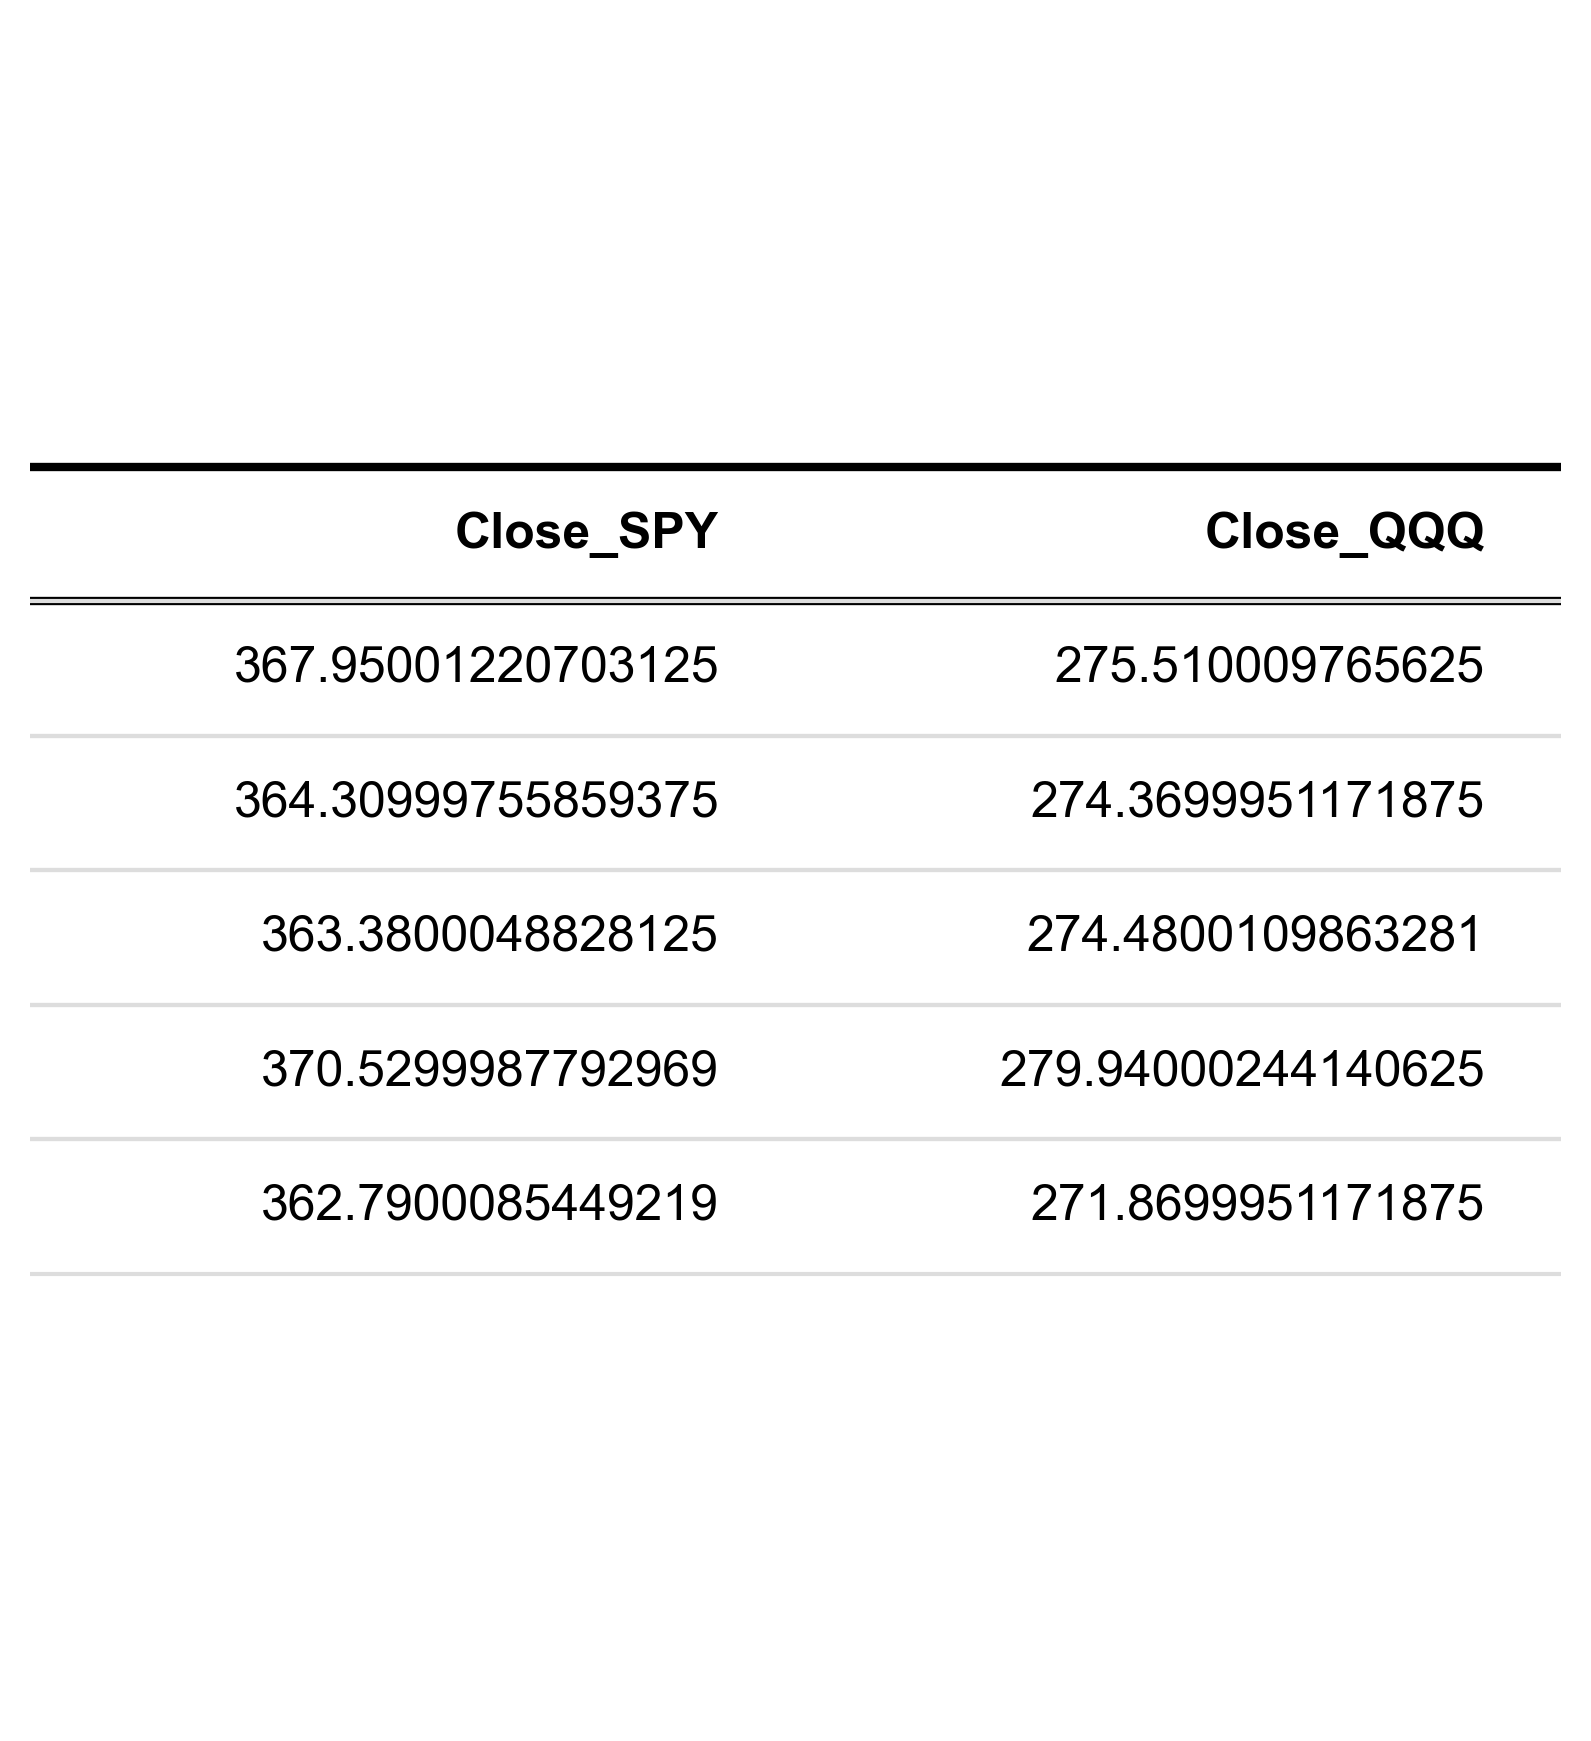

In [ ]:
#| eval: false
value = utils.download_prices('SPY', '5y')
becnhmark = utils.download_prices('QQQ', '5y')
table = pd.merge(value, becnhmark, on = 'Date', suffixes = ['_SPY', '_QQQ']).tail(5)
plot_table(table)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()